The Paper
https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Shi_Real-Time_Single_Image_CVPR_2016_paper.pdf

https://arxiv.org/abs/1707.05425

https://arxiv.org/abs/1609.05158

# Implementing ESPCN for efficient SISR

The Concept

SISR
Single Image Super Resolution

LR - Image (Low Resolution) and
HR - Image (High Resolution) Pairs
are mapped to each other (SR - Super Resolution) in order to be able to improve the Resolution on novel Images.

Problem: Previous SISR Techniques are too complex, thereby too slow.

Solution: 
Reorder steps to improve performance (first employ image enhancement, then Super Resolution)
Instead of using handcrafted bilinear filters, let CNN learn upscaling filters itself.
Getting rid of gradual stepwise upscaling, only perform SR at the End

Result: Speeds fast enough to do real-time upscaling with modern full hd-videos



#The Data


In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
!pip install tfds-nightly
import tensorflow_datasets as tfds
# Load the TensorBoard notebook extension
#%load_ext tensorboard
from datetime import datetime
import cv2

In [0]:
train = tfds.load("div2k/bicubic_x3", split = 'train')
#val = tfds.load("div2k/bicubic_x3", split = 'validation')

#No need for shuffle, it comes shuffled

# Batch
#BATCHSIZE = 1
#train = train.batch(BATCHSIZE)
#val = val.batch(BATCHSIZE)

SampleNr = 10
train_hrList = []
train_lrList = []
#val_hrList = []
#val_lrList = []

for features in train.take(SampleNr):
  hr, lr = features["hr"], features["lr"]
  train_hrList.append(hr)
  train_lrList.append(lr)
# for features in val.take(int(SampleNr/10)):
#   hr, lr = features["hr"], features["lr"]
#   val_hrList.append(hr)
#   val_lrList.append(lr)
#print(train_hrList[0])


(1536, 2040, 3) <dtype: 'uint8'>


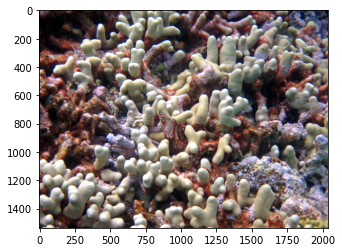

In [3]:
#See If the images made the import
#Show first IMG
imgfirst = train_hrList[0]
print(imgfirst.shape, imgfirst.dtype)
plt.imshow(imgfirst)

(512, 680, 3) <dtype: 'uint8'>


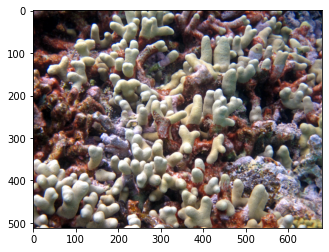

In [4]:
#Show first img in LR
imgfirst_lr = train_lrList[0]
print(imgfirst_lr.shape, imgfirst_lr.dtype)
plt.imshow(imgfirst_lr)

(1152, 2040, 3) <dtype: 'uint8'>


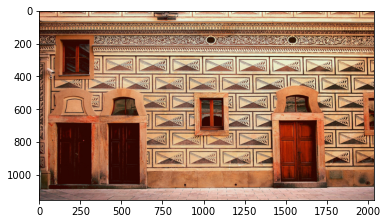

In [5]:
#Show last Img
imglast = train_hrList[SampleNr-1]
print(imglast.shape, imglast.dtype)
plt.imshow(imglast)

#Preprocessing



Image Normalization

For better performance, we want to keep only the luminance channel of the YUV Color space, since humans are most perceptive to luminance, and a simple greyscale conversion does not preserve the luminance.

In [0]:
#Cast into floats and normalize between 0 and 1
for count, img in enumerate(train_hrList):
  train_hrList[count] = tf.cast(train_hrList[count], dtype="float32")
  train_hrList[count] = train_hrList[count] / 255
#Same for Low Res
for count, img in enumerate(train_lrList):
  train_lrList[count] = tf.cast(train_lrList[count], dtype="float32")
  train_lrList[count] = train_lrList[count] / 255

#img = tf.image.per_image_standardization(img) # this doesnt work as it normalizes to [-1,1], we need [0,1]

In [0]:
# Convert to YUV color space
# This function needs normalized values between 0 and 1
yuvHrList = []
yuvLrList = []

for count, img in enumerate(train_hrList):
  img = tf.image.rgb_to_yuv(img)
  img = img.numpy()
  # only keep luminance channel
  img = img[:,:,[0]]
  # remove channel dimension
  img = tf.squeeze(img)
 
  #Bring image into correct format for patching, which is [1,x,y,1]
  img = tf.convert_to_tensor(img)
  img = tf.expand_dims(img, 0)
  img = tf.expand_dims(img, 3)

  yuvHrList.append(img)
  
#Same for Low Res
for count, img in enumerate(train_lrList):
  img = tf.image.rgb_to_yuv(img)
  img = img.numpy()
  # only keep luminance channel
  img = img[:,:,[0]]
  # remove channel dimension
  img = tf.squeeze(img)

  #Bring image into correct format for patching, which is [1,x,y,1]
  img = tf.convert_to_tensor(img)
  img = tf.expand_dims(img, 0)
  img = tf.expand_dims(img, 3)

  yuvLrList.append(img)

#print(yuvHrList)

Patching
Here, we create patches of size 17r * 17r

this ensures a uniform feed size and entails that a few borders of the images are cut, since we only accept complete patches

In [8]:
R = 3
patchscale = 17
hr_patchsize = [1, patchscale * R,patchscale * R, 1]
lr_patchsize = [1, R,R, 1]


#we want no gaps in between the patches
hr_strides = hr_patchsize
lr_strides = lr_patchsize
# This will be a list of Tensors 
train_hrList_patched = []
train_lrList_patched = []
#val_hrList_patched = []
#val_lrList_patched = []

train_hrList_patched = [tf.image.extract_patches(images=img, 
                                                 sizes=[1,51,51,1], 
                                                 strides=[1,51,51,1], 
                                                 rates=[1,1,1,1], 
                                                 padding="VALID") for img in yuvHrList]


train_lrList_patched = [tf.image.extract_patches(images=img, 
                                                 sizes=[1,17,17,1], 
                                                 strides=[1,17,17,1], 
                                                 rates=[1,1,1,1], 
                                                 padding="VALID") for img in yuvLrList]

print(train_hrList_patched[1].shape, train_lrList_patched[1].shape)

(1, 26, 40, 2601) (1, 26, 40, 289)


In [9]:
train_hrList_patched = [tf.reshape(tensor, [1,-1,51,51]) for tensor in train_hrList_patched]
train_lrList_patched = [tf.reshape(tensor, [1,-1,17,17]) for tensor in train_lrList_patched]
train_hr_data = tf.concat([tensor for tensor in train_hrList_patched], 1)
train_lr_data = tf.concat([tensor for tensor in train_lrList_patched], 1)
train_hr_data = train_hr_data[0]
train_lr_data = train_lr_data[0]
print(train_hr_data.shape, train_lr_data.shape)
#patches of all images ordered along first axis for HR and LR

(10280, 51, 51) (10280, 17, 17)


In [10]:
train_hr_data2 = tf.expand_dims(train_hr_data, -1)
train_lr_data2 = tf.expand_dims(train_lr_data, -1)
print(train_hr_data2.shape, train_lr_data2.shape)
#added 1 extra dimension, because model was crying for one

(10280, 51, 51, 1) (10280, 17, 17, 1)


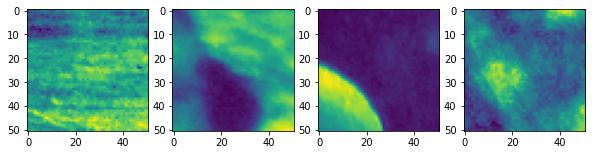

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
ax[0].imshow(train_hr_data[5999])
ax[1].imshow(train_hr_data[999])
ax[2].imshow(train_hr_data[99])
ax[3].imshow(train_hr_data[9])

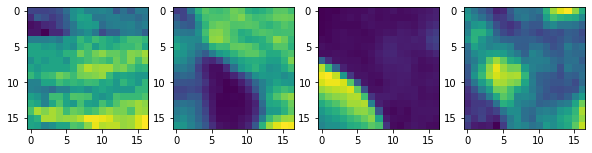

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
ax[0].imshow(train_lr_data[5999])
ax[1].imshow(train_lr_data[999])
ax[2].imshow(train_lr_data[99])
ax[3].imshow(train_lr_data[9])

# Phase Shift Implementation
https://github.com/atriumlts/subpixel
https://github.com/atriumlts/subpixel/blob/master/keras_subpixel.py

TODO 
Describe what Phase shift is doing

#Subpixel Layer



In [13]:
from keras import backend as K
from keras.layers import Conv2D
class Subpixel(Conv2D):
    def __init__(self,
                 filters,
                 kernel_size,
                 r,
                 padding='valid',
                 data_format=None,
                 strides=(1,1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(Subpixel, self).__init__(
            filters=r*r*filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.r = r

    def _phase_shift(self, I):
        r = self.r
        bsize, a, b, c = I.shape
        bsize = K.shape(I)[0] # Handling Dimension(None) type for undefined batch dim
        X = K.reshape(I, [bsize, a, b, c/(r*r),r, r]) # bsize, a, b, c/(r*r), r, r
        X = K.permute_dimensions(X, (0, 1, 2, 5, 4, 3))  # bsize, a, b, r, r, c/(r*r)
        #Keras backend does not support tf.split, so in future versions this could be nicer
        X = [X[:,i,:,:,:,:] for i in range(a)] # a, [bsize, b, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, b, a*r, r, c/(r*r)
        X = [X[:,i,:,:,:] for i in range(b)] # b, [bsize, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, a*r, b*r, c/(r*r)
        return X

    def call(self, inputs):
        return self._phase_shift(super(Subpixel, self).call(inputs))

    def compute_output_shape(self, input_shape):
        unshifted = super(Subpixel, self).compute_output_shape(input_shape)
        return (unshifted[0], self.r*unshifted[1], self.r*unshifted[2], unshifted[3]/(self.r*self.r))

    def get_config(self):
        config = super(Conv2D, self).get_config()
        config.pop('rank')
        config.pop('dilation_rate')
        config['filters']/=self.r*self.r
        config['r'] = self.r
        return config


Using TensorFlow backend.


#The Model

TODO 
Layer Configuration


In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, Activation
from keras.optimizers import Adam
from keras.losses import mean_squared_error

inputs=Input((17,17,1))
x = Conv2D(64, (5,5), activation='tanh')(inputs)
x = Conv2D(32, (3,3), activation='tanh')(x)	
x = Subpixel(3, kernel_size=(3,3), r=3, activation='tanh', data_format='channels_last')(x)
model = Model(inputs=inputs, outputs=x)
model.compile(optimizer = Adam(), loss = mean_squared_error)
model.summary()

TypeError: ignored

In [0]:
keras.backend.clear_session()
model.fit(x=train_lr_data2, y=train_hr_data2, batch_size=32, epochs=5, validation_split=0.2)

#Training

#Visualization

#Resources

